# MLP

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

class MLPRegressor(nn.Module):
    def __init__(self, input_dim: int, hidden_dims: list[int], dropout: float, output_size: int = 1):
        super().__init__()
        layers = []
        in_dim = input_dim
        for h in hidden_dims:
            layers.append(nn.Linear(in_dim, h))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
            in_dim = h
        layers.append(nn.Linear(in_dim, output_size))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        # Accept (B, L, F) or (B, L*F)
        if x.dim() == 3:
            b, l, f = x.shape
            x = x.view(b, l * f)
        out = self.net(x)
        return out.squeeze(-1)


In [9]:
import os
import pickle
import pandas as pd
import numpy as np
import torch
import torch.nn as nn

# ----- Utility: Dynamically reconstruct MLP from a saved state_dict -----
class DynamicMLP(nn.Module):
    def __init__(self, layer_dims: list[int]):
        super().__init__()
        layers = []
        for i in range(len(layer_dims) - 1):
            in_dim, out_dim = layer_dims[i], layer_dims[i+1]
            layers.append(nn.Linear(in_dim, out_dim))
            if i < len(layer_dims) - 2:
                layers.append(nn.ReLU())
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

def build_mlp_from_state_dict(state_dict: dict) -> DynamicMLP:
    """Infer MLP layer sizes from Linear weights in state_dict and construct the model."""
    linear_weights = [(k, v.shape) for k, v in state_dict.items() if k.endswith('.weight')]
    # Sort by module order if present (e.g., 'net.0.weight', 'net.3.weight', ...)
    def sort_key(item):
        k = item[0]
        parts = k.split('.')
        idxs = [int(p) for p in parts if p.isdigit()]
        return idxs[0] if idxs else 0
    linear_weights.sort(key=sort_key)
    layer_dims = []
    for _, shape in linear_weights:
        out_dim, in_dim = shape
        if not layer_dims:
            layer_dims = [in_dim, out_dim]
        else:
            layer_dims.append(out_dim)
    return DynamicMLP(layer_dims)

# ----- Loader: load model from ./models/best_10.pth -----
def load_saved_mlp(model_path: str, device: torch.device = None) -> nn.Module:
    device = device or torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    ckpt = torch.load(model_path, map_location=device)
    if isinstance(ckpt, dict) and 'state_dict' in ckpt:
        state_dict = ckpt['state_dict']
    elif isinstance(ckpt, dict):
        state_dict = ckpt
    else:
        raise ValueError('Unexpected checkpoint format. Expected a state_dict or dict with state_dict key.')
    model = build_mlp_from_state_dict(state_dict).to(device)
    model.load_state_dict(state_dict)
    model.eval()
    return model

# ----- Feature order: read from processed_data_10.pkl produced in project_data_process -----
def get_feature_order_from_processed(N: int = 10) -> list[str]:
    pkl_path = f'processed_data_{N}.pkl'
    with open(pkl_path, 'rb') as f:
        data = pickle.load(f)
    # feature_trained_name contains base names (e.g., 'Bitcoin', 'Apple', ...)
    feature_names = data.get('feature_trained_name')
    if feature_names is None:
        raise ValueError('feature_trained_name not found in processed data.')
    # Convert to log-return column names
    feature_cols = [f'{name}_LogReturn' for name in feature_names]
    return feature_cols

# ----- Load precomputed unshuffled windows from .pth -----
def load_unshuffled_windows(N: int = 10, device: torch.device = None):
    device = device or torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    path = f'processed_data_{N}_unshuffle.pth'
    if not os.path.exists(path):
        raise FileNotFoundError(f"Expected {path} not found. Generate via project_data_process.ipynb Cell 17.")
    blob = torch.load(path, map_location=device)
    X_train_unshuffle = blob['X_train']  # shape: (num_sequences, window_size, num_features)
    y_train_unshuffle = blob['y_train']  # shape: (num_sequences, window_size, num_features)
    return X_train_unshuffle.to(device), y_train_unshuffle.to(device)

# ----- Apply predicted log-return to S&P500 raw prices from the 10th data point -----

def apply_log_returns_to_price(prices: np.ndarray, start_index: int, pred_log_returns: np.ndarray) -> np.ndarray:
    """
    Given raw prices and predicted log-returns sequence, apply cumulatively
    starting from start_index (e.g., 9 for 10th data point).
    prices: array of raw S&P500 prices
    pred_log_returns: array of log-return predictions aligned with subsequent steps
    Returns an array of reconstructed prices of length len(pred_log_returns)+1 starting at prices[start_index].
    """
    out = [prices[start_index]]
    for r in pred_log_returns:
        next_price = out[-1] * (np.exp(float(r)))
        # print(np.exp(float(r)))
        # print("gan")
        out.append(next_price)
    return np.array(out)

def reconstruct_using_real_prices(prices, start_index, pred_log_returns):
    """
    prices: raw S&P500 prices
    start_index: where your model starts predicting (N-1)
    pred_log_returns: model predictions aligned with windows
    """
    out = []

    for i, r in enumerate(pred_log_returns):
        real_price = prices[start_index + i]
        predicted_price = real_price * np.exp(float(r))
        out.append(predicted_price)

    return np.array(out)


def apply_log_returns_to_price_time_series(prices: np.ndarray, start_index: int, pred_log_returns: np.ndarray) -> np.ndarray:
    """
    Given raw prices and predicted log-returns sequence, apply cumulatively
    starting from start_index (e.g., 9 for 10th data point).
    prices: array of raw S&P500 prices
    pred_log_returns: array of log-return predictions aligned with subsequent steps
    Returns an array of reconstructed prices of length len(pred_log_returns)+1 starting at prices[start_index].
    """
    out = [prices[start_index]]
    for r in pred_log_returns:
        next_price = out[-1] * (np.exp(float(r+0.00045595086117771453)))
        # print(np.exp(float(r)))
        out.append(next_price)
    return np.array(out)


import numpy as np

def reconstruct_prices_with_recalibration(
    real_prices: np.ndarray,
    pred_log_returns: np.ndarray,
    start_index: int,
    recalibration_interval: int = 10,
    mean_bias: float = 0.0
):
    """
    Reconstruct prices from predicted log-returns, recalibrating to
    the real price every `recalibration_interval` days.

    Parameters
    ----------
    real_prices : np.ndarray
        Actual historical prices.
    pred_log_returns : np.ndarray
        Predicted log returns aligned with future timesteps.
    start_index : int
        Index in real_prices where reconstruction begins.
    recalibration_interval : int
        How often to reset the reconstructed price to the real price.
    mean_bias : float
        Optional constant bias to add to predicted log returns.

    Returns
    -------
    np.ndarray
        Reconstructed price series, same length as pred_log_returns + 1.
    """

    rec_prices = [real_prices[start_index]]  # start from the real price
    current_price = real_prices[start_index]

    for i, r in enumerate(pred_log_returns):

        # Apply prediction + optional mean bias
        current_price = current_price * np.exp(float(r + mean_bias))
        rec_prices.append(current_price)

        # --- Recalibration Step ---
        if (i + 1) % recalibration_interval == 0:
            real_idx = start_index + i + 1
            if real_idx < len(real_prices):
                # Reset to ground truth to remove drift
                current_price = real_prices[real_idx]
                rec_prices[-1] = current_price  # replace the reconstructed value

    return np.array(rec_prices)

print("Functions ready: load_saved_mlp, get_feature_order_from_processed, load_unshuffled_windows, apply_log_returns_to_price")


Functions ready: load_saved_mlp, get_feature_order_from_processed, load_unshuffled_windows, apply_log_returns_to_price


In [10]:
# Runner: Load unshuffled windows, normalize, and run MLP predictions
import numpy as np
import pandas as pd
import torch
import re

# Config
N = 10
model_path = './models/best_mlp_10.pth'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load unshuffled training windows
X_train_unshuffle, _ = load_unshuffled_windows(N=N, device=device)  # (B, L, F)
B, L, F = X_train_unshuffle.shape
input_dim = L * F

# Per-feature normalization using training statistics (mean/std over all sequences and timesteps)
feat_mean = X_train_unshuffle.mean(dim=(0, 1), keepdim=True)  # (1,1,F)
feat_std = X_train_unshuffle.std(dim=(0, 1), keepdim=True)    # (1,1,F)
# Avoid division by zero
feat_std = torch.where(feat_std < 1e-8, torch.tensor(1.0, device=device), feat_std)
X_norm = (X_train_unshuffle - feat_mean) / feat_std  # (B,L,F)

# Reconstruct original MLPRegressor architecture
hidden_dims = [256, 128, 64]
dropout = 0.2
mlp = MLPRegressor(input_dim=input_dim, hidden_dims=hidden_dims, dropout=dropout, output_size=1).to(device)

# Load checkpoint weights with non-strict to handle non-param layers positions
ckpt = torch.load(model_path, map_location=device)
state_dict = ckpt['state_dict'] if isinstance(ckpt, dict) and 'state_dict' in ckpt else ckpt
missing, unexpected = mlp.load_state_dict(state_dict, strict=False)
mlp.eval()

# Flatten normalized sequences to match MLP input (B, N*F)
X_flat = X_norm.reshape(B, input_dim)

# Predict log-returns for each sequence
with torch.no_grad():
    preds_mlp = mlp(X_flat).cpu().numpy()  # shape: (B,)

# Load raw S&P500 prices from data.csv
raw_df = pd.read_csv('data.csv')

raw_df = raw_df.iloc[::-1].reset_index(drop=True)


# Try to identify the S&P500 column robustly
candidates = [
    r"^S&P\s*500$", r"^S&P500$", r"^SP\s*500$", r"^SP500$",
    r"^S\s*&\s*P\s*500$", r"^SandP\s*500$"
]
price_col = None
for pat in candidates:
    matches = [col for col in raw_df.columns if re.match(pat, str(col), flags=re.IGNORECASE)]
    if matches:
        price_col = matches[0]
        break
if price_col is None:
    lower_cols = [c.lower() for c in raw_df.columns]
    heuristics = ["sp", "s&p", "sandp", "standard & poor"]
    for h in heuristics:
        for i, lc in enumerate(lower_cols):
            if h in lc:
                price_col = raw_df.columns[i]
                break
        if price_col:
            break
if price_col is None:
    raise KeyError("Could not locate S&P500 price column in data.csv.")

sp500_prices = raw_df[price_col].values

# Reconstruct trajectory from the 10th data point (index 9)
recon_prices_mlp = apply_log_returns_to_price(sp500_prices, start_index=N-1, pred_log_returns=preds_mlp)

print({
    'num_sequences': int(B),
    'input_shape': (int(B), int(L), int(F)),
    'flat_shape': (int(B), int(input_dim)),
    'missing_keys': missing,
    'unexpected_keys': unexpected,
    'price_col': str(price_col),
    'first_pred': float(preds_mlp[0]) if len(preds_mlp) else None,
    'start_price': float(sp500_prices[N-1]),
    'recon_len': len(recon_prices_mlp)
})


{'num_sequences': 563, 'input_shape': (563, 10, 10), 'flat_shape': (563, 100), 'missing_keys': [], 'unexpected_keys': [], 'price_col': 'S&P_500', 'first_pred': -0.0008793417364358902, 'start_price': 3289.29, 'recon_len': 564}


# Transformer

In [11]:

# ---------- Positional Encoding ----------
class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, dropout: float = 0.0, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # (1, max_len, d_model)
        self.register_buffer('pe', pe)

    def forward(self, x):
        # x: (B, L, d_model)
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)

# ---------- Time Series Transformer ----------
class TimeSeriesTransformer(nn.Module):
    def __init__(self, input_size: int, d_model: int, n_heads: int,
                 num_encoder_layers: int, dim_feedforward: int, dropout: float,
                 output_size: int = 1):
        super().__init__()
        self.input_proj = nn.Linear(input_size, d_model)
        self.pos_enc = PositionalEncoding(d_model, dropout)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=n_heads,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)
        self.head = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Linear(d_model, d_model // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model // 2, output_size)
        )

    def forward(self, x):
        # x: (B, L, input_size)
        x = self.input_proj(x)           # (B, L, d_model)
        x = self.pos_enc(x)              # add positional encoding
        y = self.encoder(x)              # (B, L, d_model)
        last = y[:, -1, :]               # use last time step
        out = self.head(last)            # (B, output_size)
        return out.squeeze(-1)


In [12]:
# Runner: Transformer predictions on normalized X_train_unshuffle (exact arch)
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import re

N = 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
transformer_path = './models/best_transformer_10.pth'

# Define architecture exactly as in training
class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, dropout: float = 0.0, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)

class TimeSeriesTransformer(nn.Module):
    def __init__(self, input_size: int, d_model: int, n_heads: int,
                 num_encoder_layers: int, dim_feedforward: int, dropout: float,
                 output_size: int = 1):
        super().__init__()
        self.input_proj = nn.Linear(input_size, d_model)
        self.pos_enc = PositionalEncoding(d_model, dropout)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=n_heads,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)
        self.head = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Linear(d_model, d_model // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model // 2, output_size)
        )
    def forward(self, x):
        x = self.input_proj(x)
        x = self.pos_enc(x)
        y = self.encoder(x)
        last = y[:, -1, :]
        out = self.head(last)
        return out.squeeze(-1)

# Load unshuffled and normalize (recompute to ensure consistency)
X_train_unshuffle, y_train_unshuffle = load_unshuffled_windows(N=N, device=device)
B, L, F = X_train_unshuffle.shape
feat_mean = X_train_unshuffle.mean(dim=(0,1), keepdim=True)
feat_std  = X_train_unshuffle.std(dim=(0,1), keepdim=True)
feat_std = torch.where(feat_std < 1e-8, torch.tensor(1.0, device=device), feat_std)
X_norm = (X_train_unshuffle - feat_mean) / feat_std

# Instantiate transformer to match training hyperparameters
d_model = 64
n_heads = 4
num_layers = 3
dim_feedforward = 128
dropout = 0.2
transformer = TimeSeriesTransformer(input_size=F, d_model=d_model, n_heads=n_heads,
                                    num_encoder_layers=num_layers, dim_feedforward=dim_feedforward,
                                    dropout=dropout, output_size=1).to(device)

# Load checkpoint from training with STRICT=True to catch mismatches
ckpt = torch.load(transformer_path, map_location=device)
state_dict = ckpt['state_dict'] if isinstance(ckpt, dict) and 'state_dict' in ckpt else ckpt

# Print diagnostic info before loading
print(f"Checkpoint keys sample: {list(state_dict.keys())[:5]}")
print(f"Model expects input_size={F}, loading from {transformer_path}")

missing, unexpected = transformer.load_state_dict(state_dict, strict=True)
print(f"Missing keys: {missing}")
print(f"Unexpected keys: {unexpected}")
transformer.eval()

with torch.no_grad():
    preds_tf = transformer(X_norm).cpu().numpy()

print(f"Predictions stats: mean={preds_tf.mean():.6e}, std={preds_tf.std():.6e}, min={preds_tf.min():.6e}, max={preds_tf.max():.6e}")

# Load S&P column
raw_df = pd.read_csv('data.csv')
raw_df = raw_df.iloc[::-1].reset_index(drop=True)

candidates = [r"^S&P\s*500$", r"^S&P500$", r"^SP\s*500$", r"^SP500$", r"^S\s*&\s*P\s*500$", r"^SandP\s*500$"]
price_col = None
for pat in candidates:
    m = [col for col in raw_df.columns if re.match(pat, str(col), flags=re.IGNORECASE)]
    if m:
        price_col = m[0]
        break
if price_col is None:
    lower_cols = [c.lower() for c in raw_df.columns]
    for h in ["sp", "s&p", "sandp", "standard & poor"]:
        for i, lc in enumerate(lower_cols):
            if h in lc:
                price_col = raw_df.columns[i]
                break
        if price_col:
            break
if price_col is None:
    raise KeyError('Could not locate S&P500 price column in data.csv.')

sp500_prices = raw_df[price_col].values
recon_prices_tf = apply_log_returns_to_price(sp500_prices, start_index=N-1, pred_log_returns=preds_tf)

print({
    'transformer_preds_len': len(preds_tf),
    'start_price': float(sp500_prices[N-1]),
    'recon_len_tf': len(recon_prices_tf),
    'price_col': str(price_col)
})


Checkpoint keys sample: ['input_proj.weight', 'input_proj.bias', 'pos_enc.pe', 'encoder.layers.0.self_attn.in_proj_weight', 'encoder.layers.0.self_attn.in_proj_bias']
Model expects input_size=10, loading from ./models/best_transformer_10.pth
Missing keys: []
Unexpected keys: []
Predictions stats: mean=-7.076168e-05, std=2.844174e-03, min=-1.465640e-03, max=6.638816e-02
{'transformer_preds_len': 563, 'start_price': 3289.29, 'recon_len_tf': 564, 'price_col': 'S&P_500'}


In [13]:
# DIAGNOSTIC: Check if we're using the right normalization stats from training
import pickle

# Load the normalization stats that were computed during training
with open(f'processed_data_{N}.pkl', 'rb') as f:
    train_data = pickle.load(f)
    X_train_original = train_data['X_train']
    
# Compute stats from the original training data
train_mean_original = X_train_original.mean(axis=(0, 1), keepdims=True)
train_std_original = X_train_original.std(axis=(0, 1), keepdims=True)

# Compare with what we computed from unshuffled
print("=== NORMALIZATION COMPARISON ===")
print(f"Mean from original X_train: {train_mean_original.ravel()[:3]}...")
print(f"Mean from X_train_unshuffle: {feat_mean.cpu().numpy().ravel()[:3]}...")
print(f"Std from original X_train: {train_std_original.ravel()[:3]}...")
print(f"Std from X_train_unshuffle: {feat_std.cpu().numpy().ravel()[:3]}...")
print(f"Mean difference: {np.abs(train_mean_original - feat_mean.cpu().numpy()).max():.2e}")
print(f"Std difference: {np.abs(train_std_original - feat_std.cpu().numpy()).max():.2e}")

# Check a few raw predictions before reconstruction
print("\n=== RAW TRANSFORMER PREDICTIONS (first 10) ===")
print(preds_tf[:10])
print(f"\nStats: mean={preds_tf.mean():.6e}, std={preds_tf.std():.6e}")
print(f"Range: [{preds_tf.min():.6e}, {preds_tf.max():.6e}]")

# Check if model is actually in eval mode
print(f"\nModel in eval mode: {not transformer.training}")
print(f"Dropout layers active: {any(m.training for m in transformer.modules() if isinstance(m, nn.Dropout))}")


=== NORMALIZATION COMPARISON ===
Mean from original X_train: [0.00538983 0.00411607 0.00210544]...
Mean from X_train_unshuffle: [0.00538983 0.00411607 0.00210544]...
Std from original X_train: [0.06493099 0.04605467 0.04072821]...
Std from X_train_unshuffle: [0.06493676 0.04605876 0.04073183]...
Mean difference: 4.29e-10
Std difference: 5.77e-06

=== RAW TRANSFORMER PREDICTIONS (first 10) ===
[-1.78888789e-04 -2.37714150e-04 -2.18566624e-04  5.80720371e-05
  1.53014087e-04 -3.34285432e-05 -5.43702627e-04 -5.06118755e-04
 -1.14953145e-05 -1.60479103e-04]

Stats: mean=-7.076168e-05, std=2.844174e-03
Range: [-1.465640e-03, 6.638816e-02]

Model in eval mode: True
Dropout layers active: False


# LSTM

In [14]:
class ImprovedLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.3):
        super(ImprovedLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # LSTM layer with dropout
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, 
                           batch_first=True, dropout=dropout if num_layers > 1 else 0)
        
        # Add dropout after LSTM
        self.dropout = nn.Dropout(dropout)
        
        # Fully connected layers
        self.fc1 = nn.Linear(hidden_size, hidden_size // 2)
        self.fc2 = nn.Linear(hidden_size // 2, output_size)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = out[:, -1, :]
        out = self.dropout(out)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        return out
    
# Reduced model complexity
# output_size = 1
# input_size = 10

# hidden_size_new = 32  # Reduced from 64
# num_layers_new = 1    # Reduced from 2
# learning_rate_new = 0.001
# num_epochs_new = 20  # More epochs but with early stopping

# # Initialize improved model
# model_improved = ImprovedLSTM(input_size, hidden_size_new, num_layers_new, output_size).to(device)

In [15]:
# Runner: LSTM predictions on normalized X_train_unshuffle
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import re

N = 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
lstm_path = './models/improved_lstm_10.pth'

# Load unshuffled and normalize (recompute to ensure consistency)
X_train_unshuffle, y_train_unshuffle = load_unshuffled_windows(N=N, device=device)
B, L, F = X_train_unshuffle.shape
feat_mean = X_train_unshuffle.mean(dim=(0,1), keepdim=True)
feat_std  = X_train_unshuffle.std(dim=(0,1), keepdim=True)
feat_std = torch.where(feat_std < 1e-8, torch.tensor(1.0, device=device), feat_std)
X_norm = (X_train_unshuffle - feat_mean) / feat_std

# Instantiate LSTM to match training hyperparameters
input_size = F
hidden_size = 32
num_layers_lstm = 1
output_size = 1
dropout_lstm = 0.3

lstm_model = ImprovedLSTM(input_size=input_size, hidden_size=hidden_size, 
                          num_layers=num_layers_lstm, output_size=output_size, 
                          dropout=dropout_lstm).to(device)

# Load checkpoint from training with STRICT=True to catch mismatches
ckpt = torch.load(lstm_path, map_location=device)
state_dict = ckpt['state_dict'] if isinstance(ckpt, dict) and 'state_dict' in ckpt else ckpt

# Print diagnostic info before loading
print(f"Checkpoint keys sample: {list(state_dict.keys())[:5]}")
print(f"Model expects input_size={input_size}, loading from {lstm_path}")

missing, unexpected = lstm_model.load_state_dict(state_dict, strict=True)
print(f"Missing keys: {missing}")
print(f"Unexpected keys: {unexpected}")
lstm_model.eval()

with torch.no_grad():
    preds_lstm = lstm_model(X_norm).cpu().numpy()

print(f"Predictions stats: mean={preds_lstm.mean():.6e}, std={preds_lstm.std():.6e}, min={preds_lstm.min():.6e}, max={preds_lstm.max():.6e}")

# Load S&P column
raw_df = pd.read_csv('data.csv')
raw_df = raw_df.iloc[::-1].reset_index(drop=True)

candidates = [r"^S&P\s*500$", r"^S&P500$", r"^SP\s*500$", r"^SP500$", r"^S\s*&\s*P\s*500$", r"^SandP\s*500$"]
price_col = None
for pat in candidates:
    m = [col for col in raw_df.columns if re.match(pat, str(col), flags=re.IGNORECASE)]
    if m:
        price_col = m[0]
        break
if price_col is None:
    lower_cols = [c.lower() for c in raw_df.columns]
    for h in ["sp", "s&p", "sandp", "standard & poor"]:
        for i, lc in enumerate(lower_cols):
            if h in lc:
                price_col = raw_df.columns[i]
                break
        if price_col:
            break
if price_col is None:
    raise KeyError('Could not locate S&P500 price column in data.csv.')

sp500_prices = raw_df[price_col].values
recon_prices_lstm = apply_log_returns_to_price(sp500_prices, start_index=N-1, pred_log_returns=preds_lstm)

print({
    'lstm_preds_len': len(preds_lstm),
    'start_price': float(sp500_prices[N-1]),
    'recon_len_lstm': len(recon_prices_lstm),
    'price_col': str(price_col)
})


Checkpoint keys sample: ['lstm.weight_ih_l0', 'lstm.weight_hh_l0', 'lstm.bias_ih_l0', 'lstm.bias_hh_l0', 'fc1.weight']
Model expects input_size=10, loading from ./models/improved_lstm_10.pth
Missing keys: []
Unexpected keys: []
Predictions stats: mean=-3.481488e-04, std=4.902492e-03, min=-8.367065e-02, max=4.202411e-02
{'lstm_preds_len': 563, 'start_price': 3289.29, 'recon_len_lstm': 564, 'price_col': 'S&P_500'}


/var/folders/40/w6l8c1fd18q5162bgks26d780000gn/T/ipykernel_61173/1076237753.py:93: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  next_price = out[-1] * (np.exp(float(r)))


In [16]:
# 

# TCN

In [17]:
# ---------- TCN building blocks ----------
class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super().__init__()
        self.chomp_size = chomp_size
    def forward(self, x):
        # x shape: (B, C, L + pad)
        if self.chomp_size == 0:
            return x
        return x[:, :, : -self.chomp_size]

class TemporalBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, dilation, padding, dropout):
        super().__init__()
        self.conv1 = nn.utils.weight_norm(
            nn.Conv1d(in_channels, out_channels, kernel_size,
                      stride=stride, padding=padding, dilation=dilation)
        )
        self.chomp1 = Chomp1d(padding)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)

        self.conv2 = nn.utils.weight_norm(
            nn.Conv1d(out_channels, out_channels, kernel_size,
                      stride=stride, padding=padding, dilation=dilation)
        )
        self.chomp2 = Chomp1d(padding)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)

        self.net = nn.Sequential(self.conv1, self.chomp1, self.relu1, self.dropout1,
                                 self.conv2, self.chomp2, self.relu2, self.dropout2)

        self.downsample = nn.Conv1d(in_channels, out_channels, 1) if in_channels != out_channels else None
        self.relu = nn.ReLU()

        # Init
        self.init_weights()

    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)

    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)

class TCN(nn.Module):
    def __init__(self, input_size, tcn_channels, kernel_size=3, dropout=0.2, output_size=1):
        super().__init__()
        layers = []
        num_levels = len(tcn_channels)
        in_ch = input_size
        for i in range(num_levels):
            out_ch = tcn_channels[i]
            dilation_size = 2 ** i
            padding = (kernel_size - 1) * dilation_size
            layers.append(TemporalBlock(in_ch, out_ch, kernel_size, stride=1,
                                        dilation=dilation_size, padding=padding, dropout=dropout))
            in_ch = out_ch
        self.tcn = nn.Sequential(*layers)

        # final head: takes last time-step's features (we'll index last element)
        self.linear = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(tcn_channels[-1], tcn_channels[-1] // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(tcn_channels[-1] // 2, output_size)
        )

    def forward(self, x):
        # x: (B, seq_len, features)
        # convert to (B, C, L) for Conv1d where C=input_size, L=seq_len
        x = x.permute(0, 2, 1).contiguous()  # (B, features, seq_len)
        y = self.tcn(x)                       # (B, channels, seq_len)
        # take the last time-step features (causal conv => last index is final)
        last = y[:, :, -1]                    # (B, channels)
        out = self.linear(last)               # (B, output_size)
        return out.squeeze(-1)

In [18]:
# Runner: TCN predictions on normalized X_train_unshuffle
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import re

N = 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
tcn_path = './models/best_tcn_10_1.pth'  # FIXED: was missing ./models/ prefix

# Load unshuffled and normalize (recompute to ensure consistency)
X_train_unshuffle, y_train_unshuffle = load_unshuffled_windows(N=N, device=device)
B, L, F = X_train_unshuffle.shape
feat_mean = X_train_unshuffle.mean(dim=(0,1), keepdim=True)
feat_std  = X_train_unshuffle.std(dim=(0,1), keepdim=True)
feat_std = torch.where(feat_std < 1e-8, torch.tensor(1.0, device=device), feat_std)

X_norm = (X_train_unshuffle - feat_mean) / feat_std
# print(X_norm)
# X_norm = torch.zeros_like(X_train_unshuffle)

# Instantiate TCN to match training hyperparameters
input_size_tcn = F
tcn_channels = [32, 32, 32]
kernel_size = 3
dropout_tcn = 0.3  # MUST match training (was 0.3, not 0.2!)
output_size = 1

tcn_model = TCN(input_size=input_size_tcn, tcn_channels=tcn_channels, 
                kernel_size=kernel_size, dropout=dropout_tcn, 
                output_size=output_size).to(device)

# Load checkpoint from training with STRICT=True to catch mismatches
ckpt = torch.load(tcn_path, map_location=device)
state_dict = ckpt['state_dict'] if isinstance(ckpt, dict) and 'state_dict' in ckpt else ckpt

# Print diagnostic info before loading
print(f"Checkpoint keys sample: {list(state_dict.keys())[:5]}")
print(f"Model expects input_size={input_size_tcn}, loading from {tcn_path}")

missing, unexpected = tcn_model.load_state_dict(state_dict, strict=True)
print(f"Missing keys: {missing}")
print(f"Unexpected keys: {unexpected}")
tcn_model.eval()

# Verify model is in eval mode and check input statistics
print(f"\nModel in training mode: {tcn_model.training}")
print(f"Input shape: {X_norm.shape}")
print(f"Input stats: mean={X_norm.mean().item():.6f}, std={X_norm.std().item():.6f}")
print(f"Input min={X_norm.min().item():.6f}, max={X_norm.max().item():.6f}")
print(f"Sample inputs from first window: {X_norm[0, :3, 0].cpu().numpy()}")

# Direct prediction on all windows (no autoregressive rollout)
# Each window predicts one step ahead, matching training setup
with torch.no_grad():
    preds_tcn = tcn_model(X_norm).cpu().numpy()  # shape: (B,)
    
# print(preds_tcn)

print(f"Predictions stats: mean={preds_tcn.mean():.6e}, std={preds_tcn.std():.6e}, min={preds_tcn.min():.6e}, max={preds_tcn.max():.6e}")

# Load S&P column
raw_df = pd.read_csv('data.csv')
raw_df = raw_df.iloc[::-1].reset_index(drop=True)

candidates = [r"^S&P\s*500$", r"^S&P500$", r"^SP\s*500$", r"^SP500$", r"^S\s*&\s*P\s*500$", r"^SandP\s*500$"]
price_col = None
for pat in candidates:
    m = [col for col in raw_df.columns if re.match(pat, str(col), flags=re.IGNORECASE)]
    if m:
        price_col = m[0]
        break
if price_col is None:
    lower_cols = [c.lower() for c in raw_df.columns]
    for h in ["sp", "s&p", "sandp", "standard & poor"]:
        for i, lc in enumerate(lower_cols):
            if h in lc:
                price_col = raw_df.columns[i]
                break
        if price_col:
            break
if price_col is None:
    raise KeyError('Could not locate S&P500 price column in data.csv.')

sp500_prices = raw_df[price_col].values
recon_prices_tcn = apply_log_returns_to_price(sp500_prices, start_index=N-1, pred_log_returns=preds_tcn)


print({
    'tcn_preds_len': len(preds_tcn),
    'start_price': float(sp500_prices[N-1]),
    'recon_len_tcn': len(recon_prices_tcn),
    'price_col': str(price_col)
})


Checkpoint keys sample: ['tcn.0.conv1.bias', 'tcn.0.conv1.weight_g', 'tcn.0.conv1.weight_v', 'tcn.0.conv2.bias', 'tcn.0.conv2.weight_g']
Model expects input_size=10, loading from ./models/best_tcn_10_1.pth
Missing keys: []
Unexpected keys: []

Model in training mode: False
Input shape: torch.Size([563, 10, 10])
Input stats: mean=0.000000, std=0.999920
Input min=-14.104436, max=8.363824
Sample inputs from first window: [ 0.75120527  1.0029169  -0.19456185]


/opt/miniconda3/envs/dsml/lib/python3.13/site-packages/torch/nn/utils/weight_norm.py:144: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


Predictions stats: mean=-1.026819e-01, std=9.106262e-02, min=-5.194631e-01, max=9.189091e-01
{'tcn_preds_len': 563, 'start_price': 3289.29, 'recon_len_tcn': 564, 'price_col': 'S&P_500'}


In [19]:
# Test single sample prediction
print("Input shape:", X_norm[0].shape)
print("Input device:", X_norm[0].device)

# Add batch dimension and ensure model is in eval mode
tcn_model.eval()
with torch.no_grad():
    single_input = X_norm[0].unsqueeze(0)  # Add batch dimension: (1, 10, 10)
    print("Input with batch dim:", single_input.shape)
    prediction = tcn_model(single_input).cpu().numpy()
    print("Prediction:", prediction)
    print("Prediction type:", type(prediction))

Input shape: torch.Size([10, 10])
Input device: cpu
Input with batch dim: torch.Size([1, 10, 10])
Prediction: [-0.13914558]
Prediction type: <class 'numpy.ndarray'>


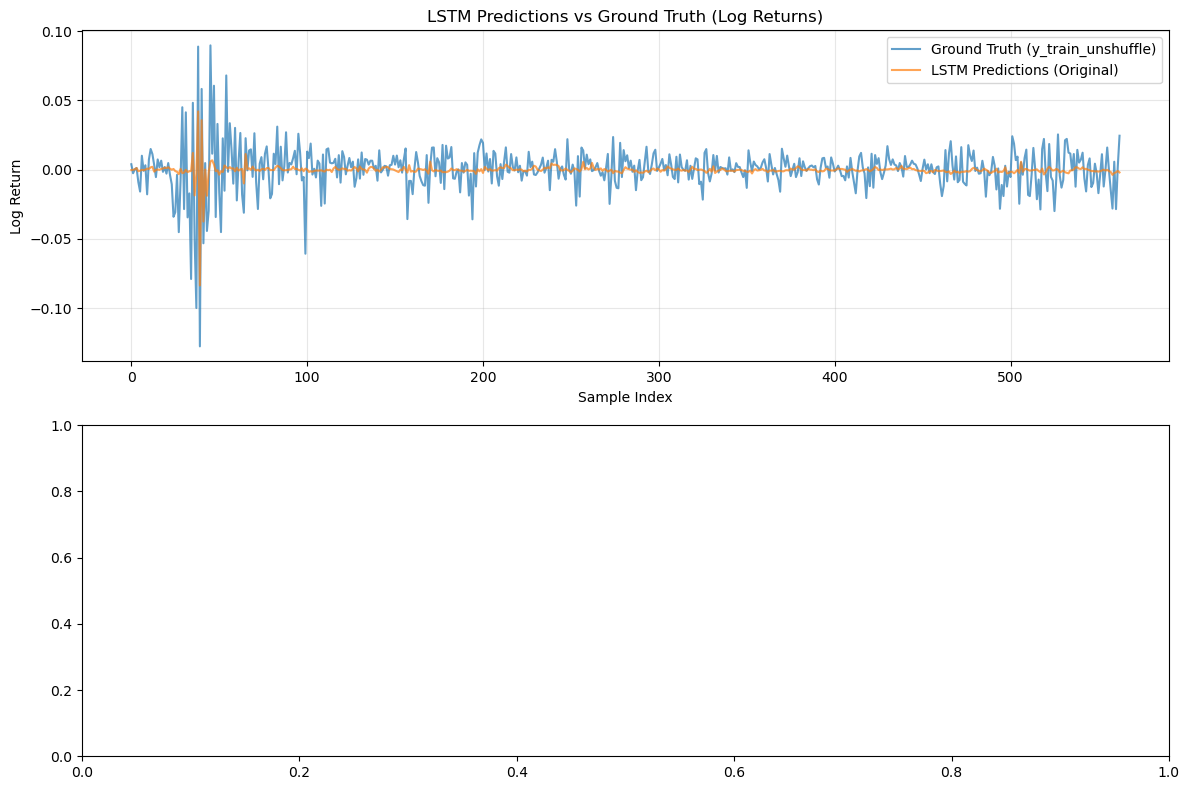

=== BEFORE CALIBRATION ===
Ground Truth: mean=4.559509e-04, std=1.639771e-02
LSTM Original: mean=-3.481488e-04, std=4.902492e-03
Std ratio (model/true): 0.2990

Note: After calibration in cell 21, std is forced to match: 1.639771e-02


In [20]:
# Plot y_train_unshuffle vs LSTM predictions (BEFORE calibration)
import matplotlib.pyplot as plt

y_train_np = y_train_unshuffle.cpu().numpy()

# Get ORIGINAL LSTM predictions (before calibration was applied in cell 21)
# Need to reload to see original predictions
lstm_model.eval()
with torch.no_grad():
    preds_lstm_original = lstm_model(X_norm).cpu().numpy()

fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# Plot 1: Direct comparison
axes[0].plot(y_train_np, label='Ground Truth (y_train_unshuffle)', alpha=0.7, linewidth=1.5)
axes[0].plot(preds_lstm_original, label='LSTM Predictions (Original)', alpha=0.7, linewidth=1.5)
axes[0].set_title('LSTM Predictions vs Ground Truth (Log Returns)')
axes[0].set_xlabel('Sample Index')
axes[0].set_ylabel('Log Return')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print ORIGINAL stats (before calibration)
sigma_true = y_train_np.std()
sigma_pred_original = preds_lstm_original.std()
mu_true = y_train_np.mean()
mu_pred_original = preds_lstm_original.mean()

print("=== BEFORE CALIBRATION ===")
print(f"Ground Truth: mean={mu_true:.6e}, std={sigma_true:.6e}")
print(f"LSTM Original: mean={mu_pred_original:.6e}, std={sigma_pred_original:.6e}")
print(f"Std ratio (model/true): {sigma_pred_original/sigma_true:.4f}")
print(f"\nNote: After calibration in cell 21, std is forced to match: {sigma_true:.6e}")


In [21]:
print("y_train_np shape:", y_train_np.shape)
print("preds_lstm shape:", np.array(preds_lstm).shape)

print("First 10 y_true:", y_train_np[:10])
print("First 10 preds:", preds_lstm[:10])


y_train_np shape: (563,)
preds_lstm shape: (563, 1)
First 10 y_true: [ 0.00385471 -0.00265548  0.00028905  0.00114031 -0.00908327 -0.01585573
  0.01000335 -0.00086722  0.00312945 -0.01786448]
First 10 preds: [[-3.4612045e-04]
 [-1.0826439e-04]
 [ 1.1528842e-04]
 [ 1.1311453e-03]
 [-1.1773068e-03]
 [-8.0785342e-04]
 [-1.5390851e-04]
 [-4.6232715e-04]
 [-7.0584938e-05]
 [ 6.9426931e-04]]


# CALIBRATION

In [22]:
# CALIBRATION: Get fresh predictions and apply mean/std calibration to all models
mu_true = y_train_np.mean()
sigma_true = y_train_np.std()

print("=== CALIBRATION ===")
print(f"Ground Truth: mean={mu_true:.6e}, std={sigma_true:.6e}\n")

# Get FRESH predictions for all models (before calibration)
# LSTM
lstm_model.eval()
with torch.no_grad():
    preds_lstm_orig = lstm_model(X_norm).cpu().numpy()
mu_pred = preds_lstm_orig.mean()
sigma_pred = preds_lstm_orig.std()
scale = sigma_true / (sigma_pred + 1e-12)
preds_lstm = (preds_lstm_orig - mu_pred) * scale + mu_true
print(f"LSTM - Before: mean={mu_pred:.6e}, std={sigma_pred:.6e}, scale={scale:.4f}")
print(f"LSTM - After:  mean={preds_lstm.mean():.6e}, std={preds_lstm.std():.6e}\n")

# TCN
tcn_model.eval()
with torch.no_grad():
    preds_tcn_orig = tcn_model(X_norm).cpu().numpy()
mu_pred = preds_tcn_orig.mean()
sigma_pred = preds_tcn_orig.std()
scale = sigma_true / (sigma_pred + 1e-12)
preds_tcn = (preds_tcn_orig - mu_pred) * scale + mu_true
print(f"TCN - Before: mean={mu_pred:.6e}, std={sigma_pred:.6e}, scale={scale:.4f}")
print(f"TCN - After:  mean={preds_tcn.mean():.6e}, std={preds_tcn.std():.6e}\n")

# MLP
mlp.eval()
with torch.no_grad():
    preds_mlp_orig = mlp(X_flat).cpu().numpy()
mu_pred = preds_mlp_orig.mean()
sigma_pred = preds_mlp_orig.std()
scale = sigma_true / (sigma_pred + 1e-12)
preds_mlp = (preds_mlp_orig - mu_pred) * scale + mu_true
print(f"MLP - Before: mean={mu_pred:.6e}, std={sigma_pred:.6e}, scale={scale:.4f}")
print(f"MLP - After:  mean={preds_mlp.mean():.6e}, std={preds_mlp.std():.6e}\n")

# Transformer
transformer.eval()
with torch.no_grad():
    preds_tf_orig = transformer(X_norm).cpu().numpy()
mu_pred = preds_tf_orig.mean()
sigma_pred = preds_tf_orig.std()
scale = sigma_true / (sigma_pred + 1e-12)
preds_tf = (preds_tf_orig - mu_pred) * scale + mu_true
print(f"TF - Before: mean={mu_pred:.6e}, std={sigma_pred:.6e}, scale={scale:.4f}")
print(f"TF - After:  mean={preds_tf.mean():.6e}, std={preds_tf.std():.6e}\n")

print("✓ All models calibrated to match ground truth mean and std")


=== CALIBRATION ===
Ground Truth: mean=4.559509e-04, std=1.639771e-02

LSTM - Before: mean=-3.481488e-04, std=4.902492e-03, scale=3.3448
LSTM - After:  mean=4.559509e-04, std=1.639771e-02

TCN - Before: mean=-1.026819e-01, std=9.106262e-02, scale=0.1801
TCN - After:  mean=4.559509e-04, std=1.639771e-02

MLP - Before: mean=1.659647e-03, std=1.257482e-02, scale=1.3040
MLP - After:  mean=4.559511e-04, std=1.639771e-02

TF - Before: mean=-7.076168e-05, std=2.844174e-03, scale=5.7654
TF - After:  mean=4.559507e-04, std=1.639771e-02

✓ All models calibrated to match ground truth mean and std


# OPEN LOOP

In [23]:
# recon_prices_tcn = apply_log_returns_to_price_time_series(sp500_prices, start_index=N-1, pred_log_returns=preds_corrected)

recon_prices_lstm = apply_log_returns_to_price(sp500_prices, start_index=N-1, pred_log_returns=preds_lstm)
recon_prices_tcn = apply_log_returns_to_price(sp500_prices, start_index=N-1, pred_log_returns=preds_tcn)
recon_prices_mlp = apply_log_returns_to_price(sp500_prices, start_index=N-1, pred_log_returns=preds_mlp)
recon_prices_tf = apply_log_returns_to_price(sp500_prices, start_index=N-1, pred_log_returns=preds_tf)

/var/folders/40/w6l8c1fd18q5162bgks26d780000gn/T/ipykernel_61173/1076237753.py:93: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  next_price = out[-1] * (np.exp(float(r)))


# PLOT

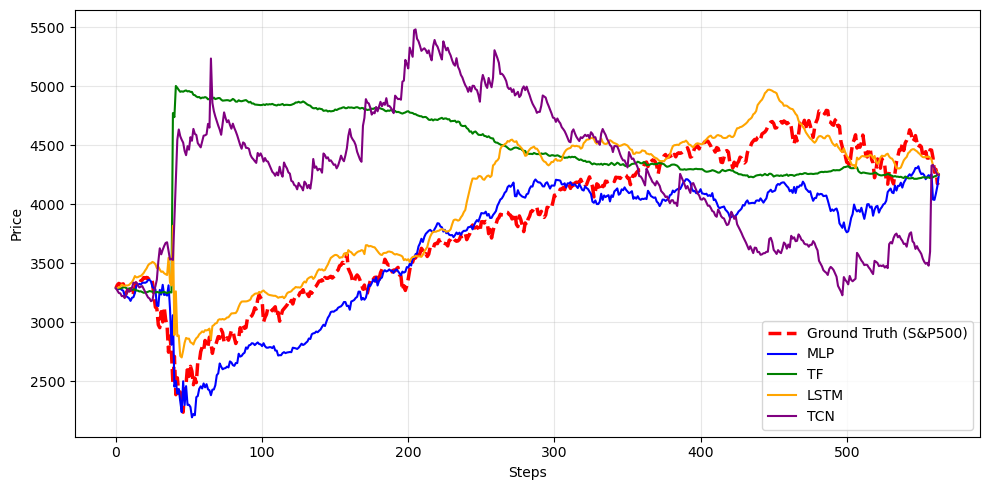

In [24]:
# Plot ground truth vs reconstructed trajectory
import matplotlib.pyplot as plt
import numpy as np

start_idx = N - 1
end_idx = start_idx + len(recon_prices_mlp) - 1

# Align ground truth slice
gt_slice = sp500_prices[start_idx:end_idx+1]
if len(gt_slice) != len(recon_prices_mlp):
    min_len = min(len(gt_slice), len(recon_prices_mlp))
    gt_slice = gt_slice[:min_len]
    recon_plot = recon_prices_mlp[:min_len]
else:
    recon_plot = recon_prices_mlp

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(gt_slice, label='Ground Truth (S&P500)', linewidth=2.5, linestyle='--', color='red')

ax.plot(recon_prices_mlp, label='MLP', color='blue')
ax.plot(recon_prices_tf, label='TF', color='green')
ax.plot(recon_prices_lstm, label='LSTM', color='orange')
ax.plot(recon_prices_tcn, label='TCN', color='purple')
# ax.set_title('S&P500 : Ground Truth vs Open-Loop Rollout')
ax.set_xlabel('Steps')
ax.set_ylabel('Price')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("./progress_report/media/prediction_openloop.pdf")
plt.show()


In [28]:
# Animated version of open-loop price predictions
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np

start_idx = N - 1
end_idx = start_idx + len(recon_prices_mlp) - 1

# Align ground truth slice
gt_slice = sp500_prices[start_idx:end_idx+1]
if len(gt_slice) != len(recon_prices_mlp):
    min_len = min(len(gt_slice), len(recon_prices_mlp))
    gt_slice = gt_slice[:min_len]
else:
    min_len = len(gt_slice)

# Truncate all reconstructed prices to same length
recon_mlp = recon_prices_mlp[:min_len]
recon_tf = recon_prices_tf[:min_len]
recon_lstm = recon_prices_lstm[:min_len]
recon_tcn = recon_prices_tcn[:min_len]

# Set up the figure and axis
fig, ax = plt.subplots(figsize=(10, 5))
ax.set_xlabel('Steps', fontsize=12)
ax.set_ylabel('Price', fontsize=12)
ax.grid(True, alpha=0.3)

# Set axis limits
ax.set_xlim(0, min_len)
y_all = np.concatenate([gt_slice, recon_mlp, recon_tf, recon_lstm, recon_tcn])
y_min = y_all.min() * 0.98
y_max = y_all.max() * 1.02
ax.set_ylim(y_min, y_max)

# Initialize empty lines
gt_line, = ax.plot([], [], label='Ground Truth (S&P500)', linewidth=2.5, linestyle='--', color='red')
mlp_line, = ax.plot([], [], label='MLP', linewidth=1.5, color='blue')
tf_line, = ax.plot([], [], label='TF', linewidth=1.5, color='green')
lstm_line, = ax.plot([], [], label='LSTM', linewidth=1.5, color='orange')
tcn_line, = ax.plot([], [], label='TCN', linewidth=1.5, color='purple')
ax.legend(loc='best', fontsize=10)

# Animation function
def animate(frame):
    idx = frame + 1
    x_data = np.arange(idx)
    
    # Update all lines
    gt_line.set_data(x_data, gt_slice[:idx])
    mlp_line.set_data(x_data, recon_mlp[:idx])
    tf_line.set_data(x_data, recon_tf[:idx])
    lstm_line.set_data(x_data, recon_lstm[:idx])
    tcn_line.set_data(x_data, recon_tcn[:idx])
    
    return gt_line, mlp_line, tf_line, lstm_line, tcn_line

# Create animation
print("Creating open-loop price animation...")
print(f"Total steps: {min_len}")
anim = FuncAnimation(fig, animate, frames=min_len, interval=20, blit=True, repeat=True)

# Save as MP4
output_path = './progress_report/media/prediction_openloop_animated.mp4'
print(f"Saving animation to {output_path}...")
anim.save(output_path, writer='ffmpeg', fps=30, dpi=100)

plt.close()

print(f"✓ Animation saved to: {output_path}")
print(f"Duration: {min_len/30:.1f} seconds at 30 fps")

Creating open-loop price animation...
Total steps: 564
Saving animation to ./progress_report/media/prediction_openloop_animated.mp4...
✓ Animation saved to: ./progress_report/media/prediction_openloop_animated.mp4
Duration: 18.8 seconds at 30 fps


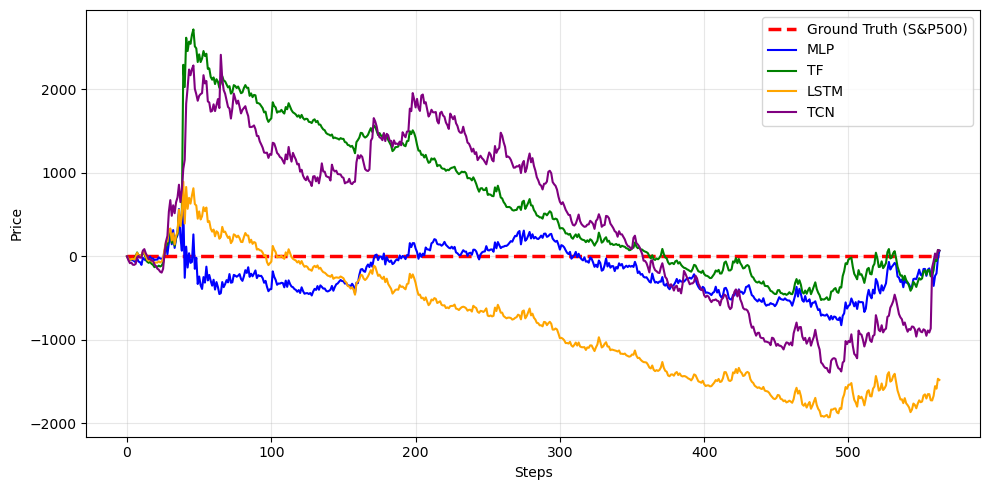

In [ ]:
# Plot ground truth vs reconstructed trajectory
import matplotlib.pyplot as plt
import numpy as np

start_idx = N - 1
end_idx = start_idx + len(recon_prices_mlp) - 1

# Align ground truth slice
gt_slice = sp500_prices[start_idx:end_idx+1]
if len(gt_slice) != len(recon_prices_mlp):
    min_len = min(len(gt_slice), len(recon_prices_mlp))
    gt_slice = gt_slice[:min_len]
    recon_plot = recon_prices_mlp[:min_len]
else:
    recon_plot = recon_prices_mlp

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(gt_slice-gt_slice, label='Ground Truth (S&P500)', linewidth=2.5, linestyle='--', color='red')

ax.plot(recon_prices_mlp-gt_slice, label='MLP', color='blue')
ax.plot(recon_prices_tf-gt_slice, label='TF', color='green')
ax.plot(recon_prices_lstm-gt_slice, label='LSTM', color='orange')
ax.plot(recon_prices_tcn-gt_slice, label='TCN', color='purple')
# ax.set_title('S&P500: Error Open-Loop (K=30) Rollout')
ax.set_xlabel('Steps')
ax.set_ylabel('Price')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("./progress_report/media/prediction_error_openloop.pdf")
plt.show()


In [30]:
import numpy as np

# Compute error series
mlp_error  = recon_prices_mlp  - gt_slice
tcn_error  = recon_prices_tcn  - gt_slice
tf_error   = recon_prices_tf   - gt_slice
lstm_error = recon_prices_lstm - gt_slice

# Mean error (bias)
mlp_me   = mlp_error.mean()
tcn_me   = tcn_error.mean()
tf_me    = tf_error.mean()
lstm_me  = lstm_error.mean()

# Mean Absolute Error
mlp_mae  = np.abs(mlp_error).mean()
tcn_mae  = np.abs(tcn_error).mean()
tf_mae   = np.abs(tf_error).mean()
lstm_mae = np.abs(lstm_error).mean()

# RMSE
mlp_rmse  = np.sqrt((mlp_error**2).mean())
tcn_rmse  = np.sqrt((tcn_error**2).mean())
tf_rmse   = np.sqrt((tf_error**2).mean())
lstm_rmse = np.sqrt((lstm_error**2).mean())

print("=== Mean Error (Bias) ===")
print(f"MLP:  {mlp_me:.6e}")
print(f"TCN:  {tcn_me:.6e}")
print(f"TF:   {tf_me:.6e}")
print(f"LSTM: {lstm_me:.6e}\n")

print("=== Mean Absolute Error ===")
print(f"MLP:  {mlp_mae:.6e}")
print(f"TCN:  {tcn_mae:.6e}")
print(f"TF:   {tf_mae:.6e}")
print(f"LSTM: {lstm_mae:.6e}\n")

print("=== RMSE ===")
print(f"MLP:  {mlp_rmse:.6e}")
print(f"TCN:  {tcn_rmse:.6e}")
print(f"TF:   {tf_rmse:.6e}")
print(f"LSTM: {lstm_rmse:.6e}")


=== Mean Error (Bias) ===
MLP:  -2.015175e+02
TCN:  4.117062e+02
TF:   5.847049e+02
LSTM: 1.747203e+02

=== Mean Absolute Error ===
MLP:  2.675538e+02
TCN:  9.523987e+02
TF:   7.487358e+02
LSTM: 2.042220e+02

=== RMSE ===
MLP:  3.254907e+02
TCN:  1.091448e+03
TF:   1.028667e+03
LSTM: 2.614431e+02


# CLOSED-LOOP

In [31]:
KK = 30

recon_prices_lstm = reconstruct_prices_with_recalibration(
    real_prices=sp500_prices,
    pred_log_returns=preds_lstm,     # your predicted log returns
    start_index=9,
    recalibration_interval=KK,
    mean_bias=0.0
)

recon_prices_tcn = reconstruct_prices_with_recalibration(
    real_prices=sp500_prices,
    pred_log_returns=preds_tcn,     # your predicted log returns
    start_index=9,
    recalibration_interval=KK,
    mean_bias=0.0
)

recon_prices_mlp = reconstruct_prices_with_recalibration(
    real_prices=sp500_prices,
    pred_log_returns=preds_mlp,     # your predicted log returns
    start_index=9,
    recalibration_interval=KK,
    mean_bias=0.0
)

recon_prices_tf = reconstruct_prices_with_recalibration(
    real_prices=sp500_prices,
    pred_log_returns=preds_tf,     # your predicted log returns
    start_index=9,
    recalibration_interval=KK,
    mean_bias=0.0
)

/var/folders/40/w6l8c1fd18q5162bgks26d780000gn/T/ipykernel_61173/1076237753.py:169: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  current_price = current_price * np.exp(float(r + mean_bias))


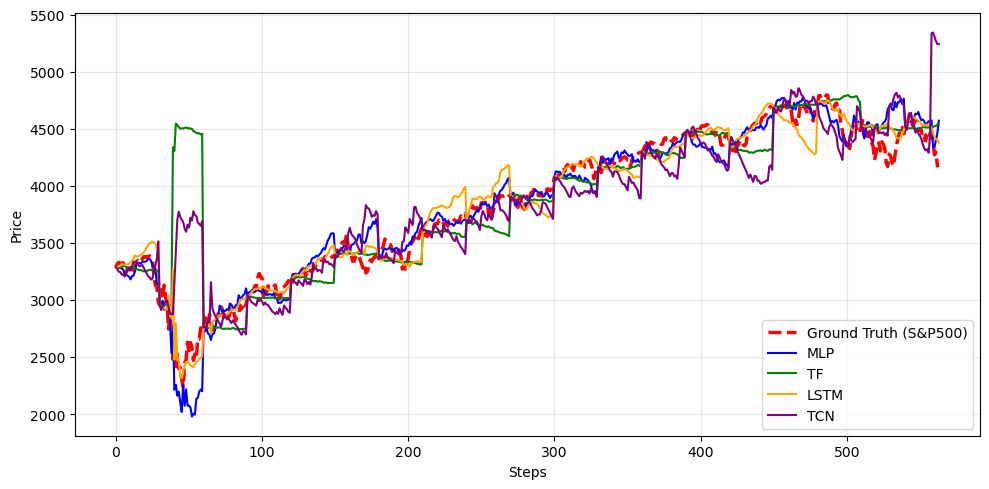

In [32]:
# Plot ground truth vs reconstructed trajectory
import matplotlib.pyplot as plt
import numpy as np

start_idx = N - 1
end_idx = start_idx + len(recon_prices_mlp) - 1

# Align ground truth slice
gt_slice = sp500_prices[start_idx:end_idx+1]
if len(gt_slice) != len(recon_prices_mlp):
    min_len = min(len(gt_slice), len(recon_prices_mlp))
    gt_slice = gt_slice[:min_len]
    recon_plot = recon_prices_mlp[:min_len]
else:
    recon_plot = recon_prices_mlp

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(gt_slice, label='Ground Truth (S&P500)', linewidth=2.5, linestyle='--', color='red')

ax.plot(recon_prices_mlp, label='MLP', color='blue')
ax.plot(recon_prices_tf, label='TF', color='green')
ax.plot(recon_prices_lstm, label='LSTM', color='orange')
ax.plot(recon_prices_tcn, label='TCN', color='purple')
# ax.set_title('S&P500: Ground Truth vs Closed-Loop (K=10) Rollout')
ax.set_xlabel('Steps')
ax.set_ylabel('Price')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("./progress_report/media/prediction_closeloop.pdf")
plt.show()


In [33]:
# Animated version of closed-loop price predictions
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np

start_idx = N - 1
end_idx = start_idx + len(recon_prices_mlp) - 1

# Align ground truth slice
gt_slice = sp500_prices[start_idx:end_idx+1]
if len(gt_slice) != len(recon_prices_mlp):
    min_len = min(len(gt_slice), len(recon_prices_mlp))
    gt_slice = gt_slice[:min_len]
else:
    min_len = len(gt_slice)

# Truncate all reconstructed prices to same length
recon_mlp = recon_prices_mlp[:min_len]
recon_tf = recon_prices_tf[:min_len]
recon_lstm = recon_prices_lstm[:min_len]
recon_tcn = recon_prices_tcn[:min_len]

# Set up the figure and axis
fig, ax = plt.subplots(figsize=(10, 5))
ax.set_xlabel('Steps', fontsize=12)
ax.set_ylabel('Price', fontsize=12)
ax.grid(True, alpha=0.3)

# Set axis limits
ax.set_xlim(0, min_len)
y_all = np.concatenate([gt_slice, recon_mlp, recon_tf, recon_lstm, recon_tcn])
y_min = y_all.min() * 0.98
y_max = y_all.max() * 1.02
ax.set_ylim(y_min, y_max)

# Initialize empty lines
gt_line, = ax.plot([], [], label='Ground Truth (S&P500)', linewidth=2.5, linestyle='--', color='red')
mlp_line, = ax.plot([], [], label='MLP', linewidth=1.5, color='blue')
tf_line, = ax.plot([], [], label='TF', linewidth=1.5, color='green')
lstm_line, = ax.plot([], [], label='LSTM', linewidth=1.5, color='orange')
tcn_line, = ax.plot([], [], label='TCN', linewidth=1.5, color='purple')
ax.legend(loc='best', fontsize=10)

# Animation function
def animate(frame):
    idx = frame + 1
    x_data = np.arange(idx)
    
    # Update all lines
    gt_line.set_data(x_data, gt_slice[:idx])
    mlp_line.set_data(x_data, recon_mlp[:idx])
    tf_line.set_data(x_data, recon_tf[:idx])
    lstm_line.set_data(x_data, recon_lstm[:idx])
    tcn_line.set_data(x_data, recon_tcn[:idx])
    
    return gt_line, mlp_line, tf_line, lstm_line, tcn_line

# Create animation
print("Creating closed-loop price animation...")
print(f"Total steps: {min_len}")
anim = FuncAnimation(fig, animate, frames=min_len, interval=20, blit=True, repeat=True)

# Save as MP4
output_path = './progress_report/media/prediction_closeloop_animated.mp4'
print(f"Saving animation to {output_path}...")
anim.save(output_path, writer='ffmpeg', fps=30, dpi=100)

plt.close()

print(f"✓ Animation saved to: {output_path}")
print(f"Duration: {min_len/30:.1f} seconds at 30 fps")

Creating closed-loop price animation...
Total steps: 564
Saving animation to ./progress_report/media/prediction_closeloop_animated.mp4...
✓ Animation saved to: ./progress_report/media/prediction_closeloop_animated.mp4
Duration: 18.8 seconds at 30 fps


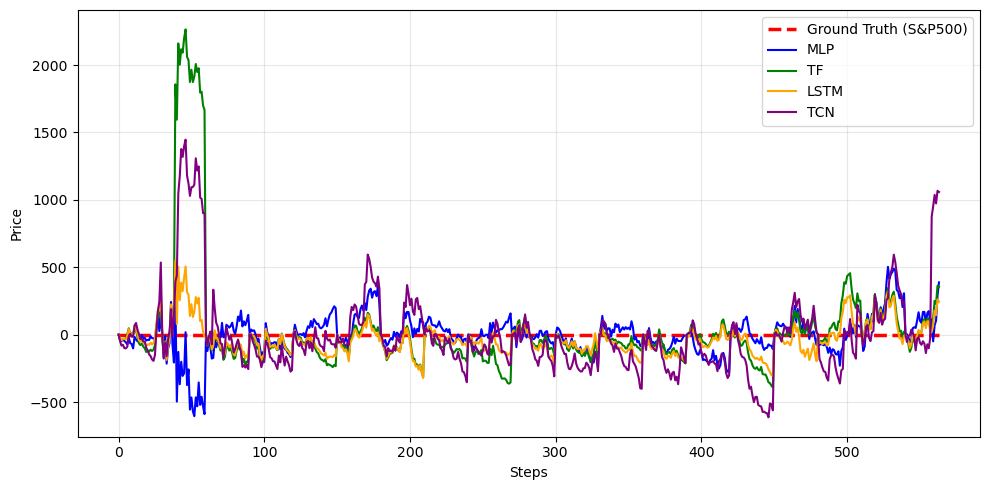

In [ ]:
# Plot ground truth vs reconstructed trajectory
import matplotlib.pyplot as plt
import numpy as np

start_idx = N - 1
end_idx = start_idx + len(recon_prices_mlp) - 1

# Align ground truth slice
gt_slice = sp500_prices[start_idx:end_idx+1]
if len(gt_slice) != len(recon_prices_mlp):
    min_len = min(len(gt_slice), len(recon_prices_mlp))
    gt_slice = gt_slice[:min_len]
    recon_plot = recon_prices_mlp[:min_len]
else:
    recon_plot = recon_prices_mlp

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(gt_slice-gt_slice, label='Ground Truth (S&P500)', linewidth=2.5, linestyle='--', color='red')

ax.plot(recon_prices_mlp-gt_slice, label='MLP', color='blue')
ax.plot(recon_prices_tf-gt_slice, label='TF', color='green')
ax.plot(recon_prices_lstm-gt_slice, label='LSTM', color='orange')
ax.plot(recon_prices_tcn-gt_slice, label='TCN', color='purple')
# ax.set_title('S&P500: Error Closed-Loop (K=10) Rollout')
ax.set_xlabel('Steps')
ax.set_ylabel('Price')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("./progress_report/media/prediction_error_closeloop.pdf")

plt.show()


In [ ]:
import numpy as np

# Compute error series
mlp_error  = recon_prices_mlp  - gt_slice
tcn_error  = recon_prices_tcn  - gt_slice
tf_error   = recon_prices_tf   - gt_slice
lstm_error = recon_prices_lstm - gt_slice

# Mean error (bias)
mlp_me   = mlp_error.mean()
tcn_me   = tcn_error.mean()
tf_me    = tf_error.mean()
lstm_me  = lstm_error.mean()

# Mean Absolute Error
mlp_mae  = np.abs(mlp_error).mean()
tcn_mae  = np.abs(tcn_error).mean()
tf_mae   = np.abs(tf_error).mean()
lstm_mae = np.abs(lstm_error).mean()

# RMSE
mlp_rmse  = np.sqrt((mlp_error**2).mean())
tcn_rmse  = np.sqrt((tcn_error**2).mean())
tf_rmse   = np.sqrt((tf_error**2).mean())
lstm_rmse = np.sqrt((lstm_error**2).mean())

print("=== Mean Error (Bias) ===")
print(f"MLP:  {mlp_me:.6e}")
print(f"TCN:  {tcn_me:.6e}")
print(f"TF:   {tf_me:.6e}")
print(f"LSTM: {lstm_me:.6e}\n")

print("=== Mean Absolute Error ===")
print(f"MLP:  {mlp_mae:.6e}")
print(f"TCN:  {tcn_mae:.6e}")
print(f"TF:   {tf_mae:.6e}")
print(f"LSTM: {lstm_mae:.6e}\n")

print("=== RMSE ===")
print(f"MLP:  {mlp_rmse:.6e}")
print(f"TCN:  {tcn_rmse:.6e}")
print(f"TF:   {tf_rmse:.6e}")
print(f"LSTM: {lstm_rmse:.6e}")


=== Mean Error (Bias) ===
MLP:  -2.601753e+00
TCN:  -8.816213e+00
TF:   3.158229e+01
LSTM: -3.438628e+01

=== Mean Absolute Error ===
MLP:  9.777886e+01
TCN:  1.932643e+02
TF:   1.734984e+02
LSTM: 9.310265e+01

=== RMSE ===
MLP:  1.431440e+02
TCN:  3.067587e+02
TF:   4.008699e+02
LSTM: 1.224571e+02


# LALALALALALA

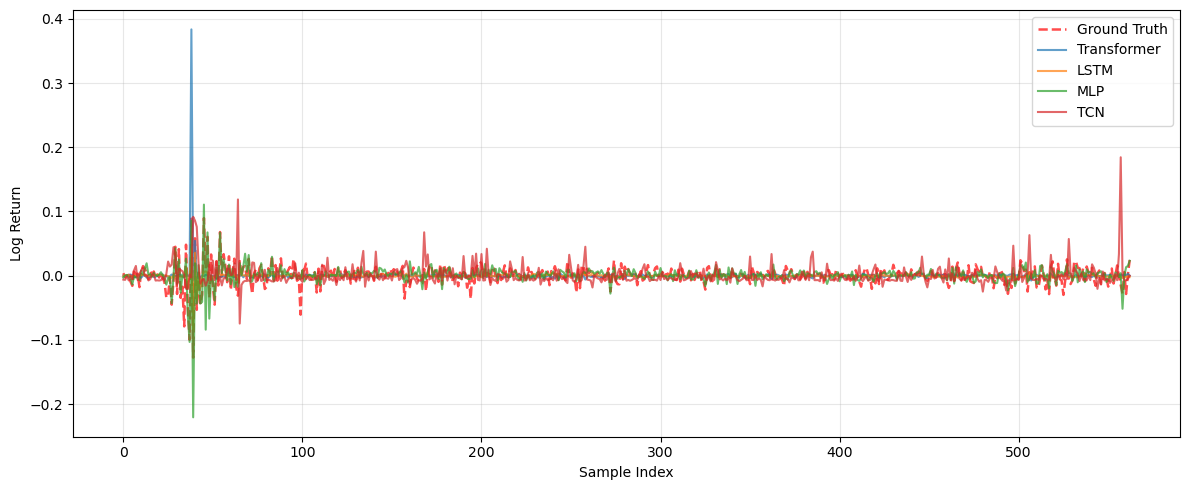

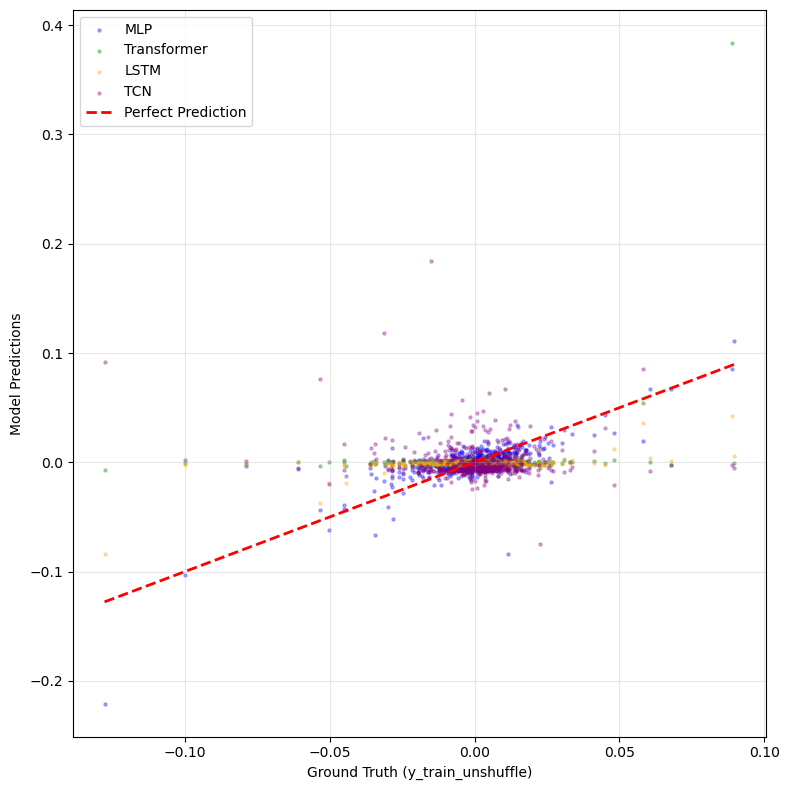


=== PERFORMANCE METRICS (AFTER CALIBRATION) ===
Ground Truth: mean=4.559509e-04, std=1.639771e-02

MLP          - MSE: 1.380804e-04, MAE: 7.612820e-03, R²: 0.486470, Corr: 0.743235
Transformer  - MSE: 4.030082e-04, MAE: 1.063944e-02, R²: -0.498813, Corr: 0.250593
LSTM         - MSE: 2.094783e-04, MAE: 9.669281e-03, R²: 0.220937, Corr: 0.523000
TCN          - MSE: 5.923092e-04, MAE: 1.448850e-02, R²: -1.202835, Corr: -0.101418


In [ ]:
# Plot y_train_unshuffle vs model predictions (after calibration) with scatter plots
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Extract ground truth - take the first feature (S&P 500) from y_train_unshuffle
# y_train_unshuffle shape: (num_sequences, window_size, num_features)
# We want the target values that correspond to each prediction
# y_train_np, _ = y_train_unshuffle[:, 0, 0].cpu().numpy()  # First timestep, first feature

# Plot 1: Time series comparison
fig1, ax1 = plt.subplots(figsize=(12, 5))
ax1.plot(y_train_np, label='Ground Truth', alpha=0.7, linewidth=1.8, color='red', linestyle="--")
ax1.plot(preds_tf, label='Transformer', alpha=0.7, linewidth=1.5)
ax1.plot(preds_lstm, label='LSTM', alpha=0.7, linewidth=1.5)
ax1.plot(preds_mlp, label='MLP', alpha=0.7, linewidth=1.5)
ax1.plot(preds_tcn, label='TCN', alpha=0.7, linewidth=1.5)
# ax1.set_title('Model Predictions vs Ground Truth (Log Returns)')
ax1.set_xlabel('Sample Index')
ax1.set_ylabel('Log Return')
ax1.legend()
ax1.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('./progress_report/media/predictions_timeseries.pdf')
plt.show()

# Plot 2: Scatter plots for all models
fig2, ax2 = plt.subplots(figsize=(8, 8))
ax2.scatter(y_train_np, preds_mlp, alpha=0.3, s=5, label='MLP', color='blue')
ax2.scatter(y_train_np, preds_tf, alpha=0.3, s=5, label='Transformer', color='green')
ax2.scatter(y_train_np, preds_lstm, alpha=0.3, s=5, label='LSTM', color='orange')
ax2.scatter(y_train_np, preds_tcn, alpha=0.3, s=5, label='TCN', color='purple')
ax2.plot([y_train_np.min(), y_train_np.max()], 
         [y_train_np.min(), y_train_np.max()], 
         'r--', label='Perfect Prediction', linewidth=2)
# ax2.set_title('Scatter Plot: Predictions vs Ground Truth')
ax2.set_xlabel('Ground Truth (y_train_unshuffle)')
ax2.set_ylabel('Model Predictions')
ax2.legend()
ax2.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('./progress_report/media/predictions_scatter.pdf')
plt.show()

# Print correlation and error metrics for all models
print("\n=== PERFORMANCE METRICS (AFTER CALIBRATION) ===")
sigma_true = y_train_np.std()
mu_true = y_train_np.mean()
print(f"Ground Truth: mean={mu_true:.6e}, std={sigma_true:.6e}\n")

for name, preds in [('MLP', preds_mlp), ('Transformer', preds_tf), 
                     ('LSTM', preds_lstm), ('TCN', preds_tcn)]:
    # Ensure preds is 1D
    preds = np.array(preds).flatten()
    mse = mean_squared_error(y_train_np, preds)
    mae = mean_absolute_error(y_train_np, preds)
    r2 = r2_score(y_train_np, preds)
    corr = np.corrcoef(y_train_np, preds)[0, 1]
    
    print(f"{name:12s} - MSE: {mse:.6e}, MAE: {mae:.6e}, R²: {r2:.6f}, Corr: {corr:.6f}")


In [26]:
# Animated version of model predictions vs ground truth
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np

# Prepare data - ensure all arrays are 1D and same length
y_train_flat = np.array(y_train_np).flatten()
preds_tf_flat = np.array(preds_tf).flatten()
preds_lstm_flat = np.array(preds_lstm).flatten()
preds_mlp_flat = np.array(preds_mlp).flatten()
preds_tcn_flat = np.array(preds_tcn).flatten()

# Find minimum length to ensure all arrays match
min_len = min(len(y_train_flat), len(preds_tf_flat), len(preds_lstm_flat), 
              len(preds_mlp_flat), len(preds_tcn_flat))

# Truncate all arrays to same length
y_train_flat = y_train_flat[:min_len]
preds_tf_flat = preds_tf_flat[:min_len]
preds_lstm_flat = preds_lstm_flat[:min_len]
preds_mlp_flat = preds_mlp_flat[:min_len]
preds_tcn_flat = preds_tcn_flat[:min_len]

max_samples = min_len

# Set up the figure and axis
fig, ax = plt.subplots(figsize=(12, 5))
ax.set_xlabel('Sample Index', fontsize=12)
ax.set_ylabel('Log Return', fontsize=12)
ax.grid(True, alpha=0.3)

# Set axis limits
ax.set_xlim(0, max_samples)
y_all = np.concatenate([y_train_flat, preds_tf_flat, preds_lstm_flat, preds_mlp_flat, preds_tcn_flat])
y_min = y_all.min() * 1.1
y_max = y_all.max() * 1.1
ax.set_ylim(y_min, y_max)

# Initialize empty lines
gt_line, = ax.plot([], [], label='Ground Truth', alpha=0.7, linewidth=1.8, color='red', linestyle='--')
tf_line, = ax.plot([], [], label='Transformer', alpha=0.7, linewidth=1.5, color='green')
lstm_line, = ax.plot([], [], label='LSTM', alpha=0.7, linewidth=1.5, color='orange')
mlp_line, = ax.plot([], [], label='MLP', alpha=0.7, linewidth=1.5, color='blue')
tcn_line, = ax.plot([], [], label='TCN', alpha=0.7, linewidth=1.5, color='purple')
ax.legend(loc='upper right', fontsize=10)

# Animation function
def animate(frame):
    # frame goes from 0 to max_samples-1
    idx = frame + 1  # Number of points to show
    
    x_data = np.arange(idx)
    
    # Update all lines
    gt_line.set_data(x_data, y_train_flat[:idx])
    tf_line.set_data(x_data, preds_tf_flat[:idx])
    lstm_line.set_data(x_data, preds_lstm_flat[:idx])
    mlp_line.set_data(x_data, preds_mlp_flat[:idx])
    tcn_line.set_data(x_data, preds_tcn_flat[:idx])
    
    return gt_line, tf_line, lstm_line, mlp_line, tcn_line

# Create animation
print("Creating predictions animation...")
print(f"Total samples: {max_samples}")
anim = FuncAnimation(fig, animate, frames=max_samples, interval=20, blit=True, repeat=True)

# Save as MP4
output_path = './progress_report/media/predictions_timeseries_animated.mp4'
print(f"Saving animation to {output_path}...")
anim.save(output_path, writer='ffmpeg', fps=30, dpi=100)

plt.close()

print(f"✓ Animation saved to: {output_path}")
print(f"Duration: {max_samples/30:.1f} seconds at 30 fps")

Creating predictions animation...
Total samples: 563
Saving animation to ./progress_report/media/predictions_timeseries_animated.mp4...
✓ Animation saved to: ./progress_report/media/predictions_timeseries_animated.mp4
Duration: 18.8 seconds at 30 fps
